In [1]:
cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/cells_meta.tsv"
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor1"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/top"
clone_order_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/clones_ranked/cloneID_rank_ncells.txt"

# cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/cells_meta.tsv"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/single"
# clone_order_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/clones_ranked/cloneID_rank_ncells.txt"

ntop_clones = -1 #unused parameters

af_thresh = 0.001
cov_thresh = 2
ntop_vars=10



In [2]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

plt.rcParams['svg.fonttype'] = 'none'

fig_utils from mplh
0.5.6


In [3]:
import seaborn as sns
from mplh import cluster_help as ch
from src.utils.data_io import reverse_ids


In [4]:
clone_order = pd.read_csv(clone_order_f, header=None)[0].values
top_clones = clone_order #clone_order[:ntop_clones]
top_clones

array(['1_10', '1_0', '1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7',
       '1_8', '1_9', '1_11', '1_12', '1_13', '1_14', '1_17', '1_15',
       '1_18', '1_16', '1_19', '1_20', '1_22', '1_21', '1_23', '1_24',
       '1_25', '1_26', '1_27', '1_28', '1_29', '1_30', '1_31', '1_32'],
      dtype=object)

In [5]:
clone_order

array(['1_10', '1_0', '1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7',
       '1_8', '1_9', '1_11', '1_12', '1_13', '1_14', '1_17', '1_15',
       '1_18', '1_16', '1_19', '1_20', '1_22', '1_21', '1_23', '1_24',
       '1_25', '1_26', '1_27', '1_28', '1_29', '1_30', '1_31', '1_32'],
      dtype=object)

In [6]:
#af_indir = join(indir, "sc_af", f"donor{DONOR}")
af_indir = indir

AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")


#out_f = join(outdir, f"donor{DONOR}")


In [7]:
#donor_vars = AF_df>0.9

In [8]:
cells_meta = pd.read_csv(cells_meta_f,sep="\t", index_col=0)
cells_meta = reverse_ids(cells_meta)
cells_meta

,cloneID,clusterID,condition,donor
AAACGAAAGAATCAGT-1_Control,1_4,eosonophil,Control,1
AAACGAAAGCATACCT-1_Control,1_30,MPP/CMP/GMP C,Control,1
AAACGAAAGTACAGTA-1_Control,1_21,eosonophil,Control,1
AAACGAAAGTGTCGGA-1_Control,1_6,erythroid,Control,1
AAACGAAGTCTTAGCA-1_Control,1_23,erythroid,Control,1
...,...,...,...,...
TTTGTGTCAATGACTC-1_Input,1_2,MPP/CMP/GMP,Input,1
TTTGTGTCAGAAAGAG-1_Input,1_4,MPP/CMP/GMP B,Input,1
TTTGTGTCATAGCCAT-1_Input,1_19,MPP/CMP/GMP B,Input,1
TTTGTGTGTCATAGAA-1_Input,1_3,MPP/CMP/GMP,Input,1


## Get donor-specific variants

In [9]:
def get_high_variants(df, thresh, pct_thresh):
    """ Remove rows that have an average higher than threshold

    :param df:
    :param thresh:
    :return:
    """
    n_pct = pct_thresh*df.shape[0]
    return df.loc[:,((df>thresh).sum()>n_pct)].columns.values


donor_vars = get_high_variants(AF_df, thresh=0.8, pct_thresh=0.9)
print(f"number of donor vars: {len(donor_vars)}")


number of donor vars: 35


## Filter for clone

In [10]:
AF_df = AF_df.transpose()
DP_df = DP_df.transpose()

In [11]:
AF_df.head()

Cell,AAACGAAAGAATCAGT-1_Control,AAACGAAAGCATACCT-1_Control,AAACGAAAGTACAGTA-1_Control,AAACGAAAGTGTCGGA-1_Control,AAACGAAGTCTTAGCA-1_Control,AAACGAAGTGTTTCTT-1_Control,AAACGAATCCCACGGA-1_Control,AAACTCGAGTCTCTAG-1_Control,AAACTCGGTCTGCACG-1_Control,AAACTCGGTTGGCTTA-1_Control,...,TTTGTGTAGGTTGTTC-1_Input,TTTGTGTAGGTTTCTG-1_Input,TTTGTGTAGTAGACCG-1_Input,TTTGTGTCAACTCGTA-1_Input,TTTGTGTCAAGCCAGA-1_Input,TTTGTGTCAATGACTC-1_Input,TTTGTGTCAGAAAGAG-1_Input,TTTGTGTCATAGCCAT-1_Input,TTTGTGTGTCATAGAA-1_Input,TTTGTGTTCGGGACAA-1_Input
10397G,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.030769,0.0,0.0,0.0,0.0,0.0
10463C,1.000000,0.962963,1.0,1.0,1.0,1.0,1.00,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0
10559G,1.000000,0.913043,1.0,1.0,1.0,1.0,1.00,0.916667,1.0,1.0,...,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0
10589A,0.000000,0.086957,0.0,0.0,0.0,0.0,0.00,0.222222,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
11251G,0.909091,0.966667,1.0,1.0,1.0,1.0,0.92,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.0,0.981651,1.0,1.0,1.0,1.0,1.0


## Remove donor-specific variants

In [12]:
# Remove Donor variannts
AF_df = AF_df.loc[~(AF_df.index.isin(donor_vars))]
DP_df = DP_df.loc[AF_df.index, AF_df.columns] 

# Figure: 1: barplot for each clone, where x=Variant, and the % of cells (and raw) in the clone that has the variant and % of cells from other clone with variant


In [13]:
top_cells_meta = cells_meta[cells_meta["cloneID"].isin(top_clones)] 
top_cells_meta

,cloneID,clusterID,condition,donor
AAACGAAAGAATCAGT-1_Control,1_4,eosonophil,Control,1
AAACGAAAGCATACCT-1_Control,1_30,MPP/CMP/GMP C,Control,1
AAACGAAAGTACAGTA-1_Control,1_21,eosonophil,Control,1
AAACGAAAGTGTCGGA-1_Control,1_6,erythroid,Control,1
AAACGAAGTCTTAGCA-1_Control,1_23,erythroid,Control,1
...,...,...,...,...
TTTGTGTCAATGACTC-1_Input,1_2,MPP/CMP/GMP,Input,1
TTTGTGTCAGAAAGAG-1_Input,1_4,MPP/CMP/GMP B,Input,1
TTTGTGTCATAGCCAT-1_Input,1_19,MPP/CMP/GMP B,Input,1
TTTGTGTGTCATAGAA-1_Input,1_3,MPP/CMP/GMP,Input,1


In [14]:
bin_AF_df = (AF_df > af_thresh) & (DP_df > cov_thresh)
bin_AF_df

Cell,AAACGAAAGAATCAGT-1_Control,AAACGAAAGCATACCT-1_Control,AAACGAAAGTACAGTA-1_Control,AAACGAAAGTGTCGGA-1_Control,AAACGAAGTCTTAGCA-1_Control,AAACGAAGTGTTTCTT-1_Control,AAACGAATCCCACGGA-1_Control,AAACTCGAGTCTCTAG-1_Control,AAACTCGGTCTGCACG-1_Control,AAACTCGGTTGGCTTA-1_Control,...,TTTGTGTAGGTTGTTC-1_Input,TTTGTGTAGGTTTCTG-1_Input,TTTGTGTAGTAGACCG-1_Input,TTTGTGTCAACTCGTA-1_Input,TTTGTGTCAAGCCAGA-1_Input,TTTGTGTCAATGACTC-1_Input,TTTGTGTCAGAAAGAG-1_Input,TTTGTGTCATAGCCAT-1_Input,TTTGTGTGTCATAGAA-1_Input,TTTGTGTTCGGGACAA-1_Input
10397G,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
10589A,False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
11453A,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11761T,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,True,False,False,False,False
13188T,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
14674C,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
146C,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
15297C,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
152C,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15497A,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Create variant-clone (and non-clone) percent of cells in clone with variant

In [15]:
def calc_clone_pct(data, **kwargs):
    curr_AF_df = bin_AF_df.loc[:,data.index]
    other_curr_AF_df = bin_AF_df.loc[:, ~(bin_AF_df.columns.isin(data.index))]
    
    curr_AF_tot = curr_AF_df.sum(axis=1)
    curr_AF_pct = curr_AF_tot/curr_AF_df.shape[1]
    
    other_curr_AF_tot = other_curr_AF_df.sum(axis=1)
    other_curr_AF_pct = other_curr_AF_tot/other_curr_AF_df.shape[1]
        
    return pd.concat((pd.DataFrame(curr_AF_pct).rename({0:"clone_pct"}, axis=1),
               pd.DataFrame(other_curr_AF_pct).rename({0:"other_clone_pct"}, axis=1)),axis=1, 
             ignore_index=False).rename_axis("variant")
    

pct_clones_df = top_cells_meta.groupby("cloneID").apply(calc_clone_pct).reset_index()
pct_clones_df

,cloneID,variant,clone_pct,other_clone_pct
0,1_0,10397G,0.040123,0.079717
1,1_0,10589A,0.020062,0.072506
2,1_0,11453A,0.004630,0.004720
3,1_0,11761T,0.192901,0.092959
4,1_0,13188T,0.216049,0.099515
...,...,...,...,...
1084,1_9,827G,0.048951,0.089623
1085,1_9,8292A,0.115385,0.093629
1086,1_9,8461T,0.090909,0.095631
1087,1_9,8743A,0.000000,0.001878


## Rank variants for each clone by sorting by mannwhitneyu test of allele-frequency


In [16]:
from scipy.stats import mannwhitneyu

In [17]:
def rank_unique_vars_clone_af(clone_cells):
    clones_af = AF_df.loc[:,clone_cells.index]
    other_clones_af = AF_df.loc[:, ~(AF_df.columns.isin(clone_cells.index))]
    pvals = mannwhitneyu(clones_af, other_clones_af, alternative='greater', axis=1).pvalue
    rankings = pd.DataFrame(index=clones_af.index,data=pvals).rank(method="min").rename({0:"rank"}, axis=1) # np.argsort(pvals)
    #print(type(rankings))
    #print('rankings', rankings)

    rankings["pval"] = pvals
    rankings["rank"]= rankings["rank"].astype('int')
    #print('rankings', rankings)
    #print('rankings', rankings.head())
    rankings.index.name = "variant"
    return rankings

pvals_df = cells_meta.groupby("cloneID").apply(rank_unique_vars_clone_af).reset_index()
pvals_df

,cloneID,variant,rank,pval
0,1_0,10397G,23,9.998688e-01
1,1_0,10589A,27,9.999998e-01
2,1_0,11453A,16,5.110583e-01
3,1_0,11761T,3,1.197150e-16
4,1_0,13188T,2,1.435831e-20
...,...,...,...,...
1084,1_9,827G,31,9.874913e-01
1085,1_9,8292A,3,6.609816e-02
1086,1_9,8461T,8,4.825801e-01
1087,1_9,8743A,17,7.683995e-01


In [18]:
pct_pvals_df = pd.merge(pct_clones_df, pvals_df, on=["cloneID", "variant"])
pct_pvals_df

,cloneID,variant,clone_pct,other_clone_pct,rank,pval
0,1_0,10397G,0.040123,0.079717,23,9.998688e-01
1,1_0,10589A,0.020062,0.072506,27,9.999998e-01
2,1_0,11453A,0.004630,0.004720,16,5.110583e-01
3,1_0,11761T,0.192901,0.092959,3,1.197150e-16
4,1_0,13188T,0.216049,0.099515,2,1.435831e-20
...,...,...,...,...,...,...
1084,1_9,827G,0.048951,0.089623,31,9.874913e-01
1085,1_9,8292A,0.115385,0.093629,3,6.609816e-02
1086,1_9,8461T,0.090909,0.095631,8,4.825801e-01
1087,1_9,8743A,0.000000,0.001878,17,7.683995e-01


In [19]:
def plot_pct_bar(data, **kwargs):
    ntop_vars = kwargs.get("ntop_vars", 0)
    data = data.set_index("variant")
    if ntop_vars != 0:
        data = data[data['rank']<ntop_vars].sort_values("rank")
        data[["clone_pct", "other_clone_pct"]].plot.bar(ax=plt.gca())
    else:
        data = data.loc[(data["clone_pct"]-data["other_clone_pct"]).sort_values()[::-1].index]
        #data = data.sort_values("clone_pct")[::-1]
        #print(data["clone_pct"]-data["other_clone_pct"])
        pd.DataFrame((data["clone_pct"]-data["other_clone_pct"])).plot.bar(ax=plt.gca())
    
    #plt.gca().legend(loc='best') 
    return

## Figure: Barplot of percent in clone vs percent not in clone

In [20]:
outdir

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/single_clones/donor1/cloneMethod_variants_init_knn_resolution_30/clonalShift_method_clones/top'

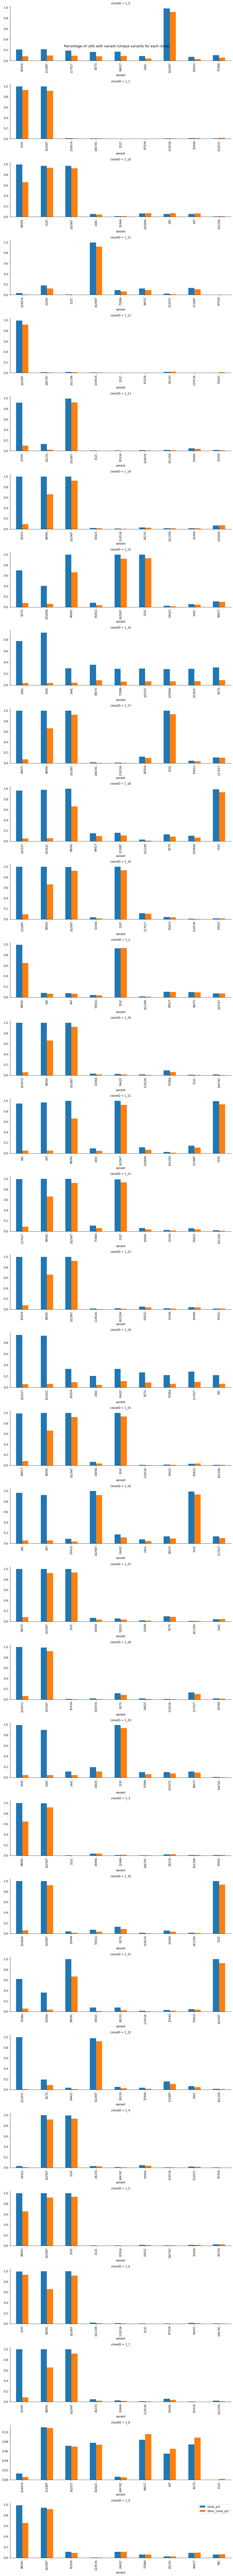

In [21]:
g = sns.FacetGrid(data=pct_pvals_df, col = "cloneID", col_wrap=1, height=4, aspect=3,
                 sharex=False, sharey=False)
g.map_dataframe(plot_pct_bar, ntop_vars=ntop_vars)
g.fig.suptitle("Percentage of cells with variant (Unique variants for each clone)")
#g.fig.savefig(fname=join(outdir, f"all_variants_distinct_pct_vs_other.pdf"), dpi=500, bbox_inches='tight', pad_inches=0.5)
g.fig.savefig(fname=join(outdir, f"all_variants_distinct_pct_vs_other.svg"), dpi=500, bbox_inches='tight', pad_inches=0.5)

plt.tight_layout()
plt.legend()

In [22]:
def plot_violin(data, **kwargs):
    ntop_vars = kwargs.get("ntop_vars", 0)
    curr_clone = data["cloneID"].values[0]
    print('curr_clone', curr_clone)
    curr_AF_df = AF_df.loc[:,data.index]
    other_curr_AF_df = AF_df.loc[:, ~(AF_df.columns.isin(data.index))]
    
    curr_AF_df = curr_AF_df.reset_index().melt(id_vars='index', var_name="cell", value_name="AF")
    curr_AF_df["type"] = "clone"
    
    other_curr_AF_df = other_curr_AF_df.reset_index().melt(id_vars='index', var_name="cell", value_name="AF")
    other_curr_AF_df["type"] = "other"
    curr_merge_df = pd.concat((curr_AF_df, other_curr_AF_df), axis=0)
    curr_merge_df = curr_merge_df.rename({"index":"variant"}, axis=1)
    print(curr_merge_df.head())
    if ntop_vars != 0:
        print(pct_pvals_df[(pct_pvals_df["cloneID"]==curr_clone)])
        if pct_pvals_df[(pct_pvals_df["cloneID"]==curr_clone)].shape[0] == 0:
            return
        curr_top_vars = pct_pvals_df[(pct_pvals_df["cloneID"]==curr_clone) & (pct_pvals_df["rank"]<=ntop_vars)].sort_values("rank")["variant"].values
        print('top vars', curr_top_vars)
        #print('before top vars',curr_merge_df.shape)
        curr_merge_df = curr_merge_df[curr_merge_df["variant"].isin(curr_top_vars)] #data[data['rank']<ntop_vars].sort_values("rank")
        #print('after top vars',curr_merge_df.shape)
        
    sns.boxenplot(data=curr_merge_df, x="variant", y="AF", hue="type", ax=plt.gca())
    return 
    

# Plot variants as row and clone as x AF violin

In [23]:
def long_af(ser, cells_meta):
    v = ser.name
    cells_meta["Variant"] = v
    #print('ser', pd.DataFrame(ser))
    cells_meta  = pd.merge(pd.DataFrame(ser).rename({v:"af"}, axis=1), 
             cells_meta, left_index=True, right_index=True, how='inner' )
    #cells_meta.loc[ser.index, "AF"] = ser
    return cells_meta
    
long_af = AF_df.apply(long_af, cells_meta=cells_meta, axis=1)
long_af = pd.concat(long_af.values, axis=0)

In [24]:
vars_min_over_median = pct_pvals_df.groupby("variant").apply(lambda x: min(x['rank']+1)/np.median(x['rank']+1))
vars_min_over_median = vars_min_over_median.sort_values()
vars_order = vars_min_over_median.index
vars_min_over_median


variant
3109C     0.062500
16355T    0.068966
16362C    0.071429
204C      0.076923
64T       0.080000
58C       0.083333
3847C     0.083333
827G      0.090909
196C      0.090909
10397G    0.090909
13188T    0.090909
8292A     0.095238
15297C    0.100000
11761T    0.111111
2442C     0.111111
10589A    0.117647
8461T     0.117647
15497A    0.117647
7598A     0.117647
5442C     0.166667
14674C    0.176471
310C      0.200000
2623G     0.214286
1949A     0.230769
8743A     0.266667
146C      0.266667
5581G     0.285714
152C      0.285714
16129A    0.333333
3244A     0.363636
11453A    0.416667
16296T    0.500000
9899C     0.500000
dtype: float64

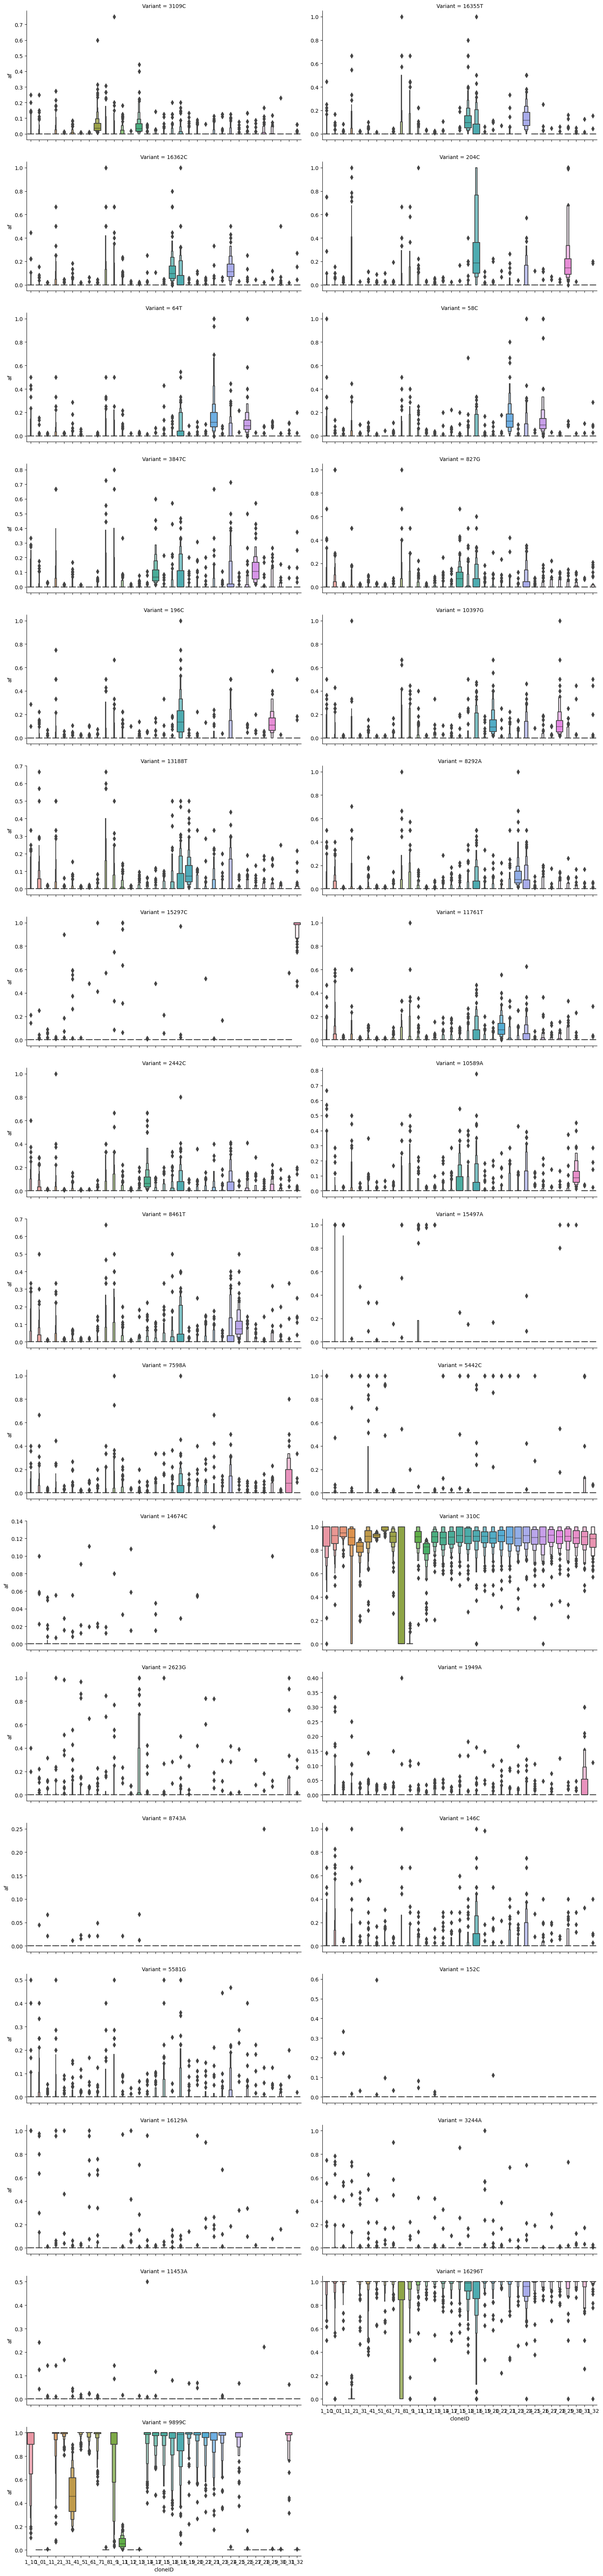

In [25]:
g = sns.catplot(data=long_af, x="cloneID", y="af", col="Variant", col_wrap=2, kind='boxen', 
            sharey=False, col_order=vars_order,
            height=4, aspect=2, order=top_clones)
#g.fig.savefig(fname=join(outdir, f"top_variants_af.pdf"), dpi=500, bbox_inches='tight', pad_inches=0.5)
g.fig.savefig(fname=join(outdir, f"all_variants_af.svg"), dpi=500, bbox_inches='tight', pad_inches=0.5)

## Overlapping variants across clones